### 1. 필요한 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

### 2. 전처리한 데이터 불러오기 및 데이터 확인

In [2]:
df = pd.read_csv('./data/result_final.csv', parse_dates=['baseYmd'])
df

,areaNm,touNum,baseYmd,avgTemp,dayRf,daySf,festival,holiday,PM10,PM25,AccumulateCovid19,increase
0,서울특별시,1.171118e+06,2022-01-01,-4.3,0.0,0.0,0,1,0,0,226698.0,1464.0
1,부산광역시,4.451020e+05,2022-01-01,1.9,0.0,0.0,0,1,0,0,25287.0,212.0
2,대구광역시,2.641135e+05,2022-01-01,-2.3,0.0,0.0,0,1,0,0,23249.0,125.0
3,인천광역시,4.966920e+05,2022-01-01,-3.4,0.0,0.0,0,1,0,0,36962.0,241.0
4,광주광역시,1.610280e+05,2022-01-01,-0.1,0.0,0.0,0,1,0,0,8118.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6200,전라북도,2.589299e+05,2022-09-03,25.3,0.0,0.0,1,1,0,0,788103.0,3442.0
6201,전라남도,3.479362e+05,2022-09-03,24.1,0.5,0.0,1,1,0,0,776823.0,3048.0
6202,경상북도,4.861745e+05,2022-09-03,21.0,0.1,0.0,0,1,0,0,1042687.0,4782.0
6203,경상남도,4.114590e+05,2022-09-03,21.0,6.6,0.0,0,1,0,0,1406209.0,5373.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6205 entries, 0 to 6204
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   areaNm             6205 non-null   object        
 1   touNum             6205 non-null   float64       
 2   baseYmd            6205 non-null   datetime64[ns]
 3   avgTemp            6205 non-null   float64       
 4   dayRf              6205 non-null   float64       
 5   daySf              6205 non-null   float64       
 6   festival           6205 non-null   int64         
 7   holiday            6205 non-null   int64         
 8   PM10               6205 non-null   int64         
 9   PM25               6205 non-null   int64         
 10  AccumulateCovid19  6205 non-null   float64       
 11  increase           6205 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 581.8+ KB


### 3. 임의의 지역을 각각의 샘플로 저장

In [4]:
# 분류하여 각 변수에 저장
df_seoul = df.loc[df['areaNm'] == '서울특별시']
df_jeju = df.loc[df['areaNm'] == '제주특별자치도']
df_gangwon = df.loc[df['areaNm'] == '강원도']
df_jeonju = df.loc[df['areaNm'] == '전라남도']
df_busan = df.loc[df['areaNm'] == '부산광역시']
df_chungju = df.loc[df['areaNm'] == '충청북도']


In [5]:
# 분류된 광역시 컬럼 삭제
df_seoul.drop(columns=['areaNm'], inplace=True)
df_jeju.drop(columns=['areaNm'], inplace=True)
df_gangwon.drop(columns=['areaNm'], inplace=True)
df_jeonju.drop(columns=['areaNm'], inplace=True)
df_busan.drop(columns=['areaNm'], inplace=True)
df_chungju.drop(columns=['areaNm'], inplace=True)

### 4. 각 샘플 데이터 확인

- 서울특별시

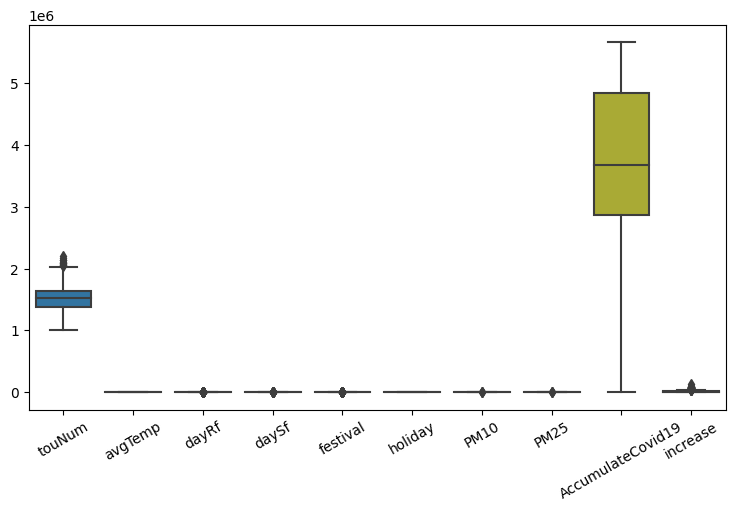

In [6]:
plt.figure(figsize=(9, 5))
seoul_box = sns.boxplot(data=df_seoul)
seoul_box.set_xticklabels(seoul_box.get_xticklabels(), rotation=30)
plt.show()

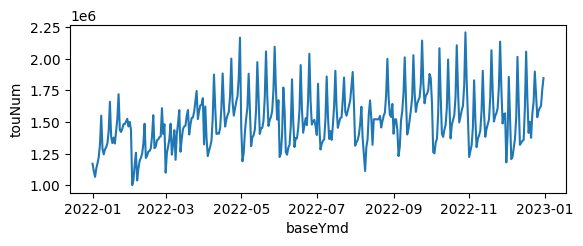

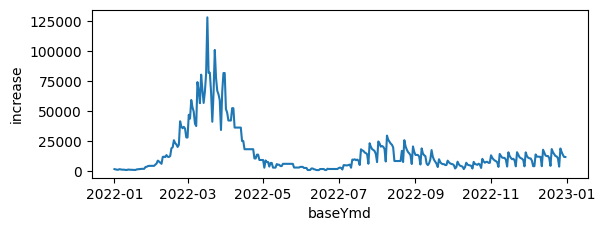

In [7]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_seoul['baseYmd'], y=df_seoul['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_seoul['baseYmd'], y=df_seoul['increase'])
plt.show()

- 제주특별자치도

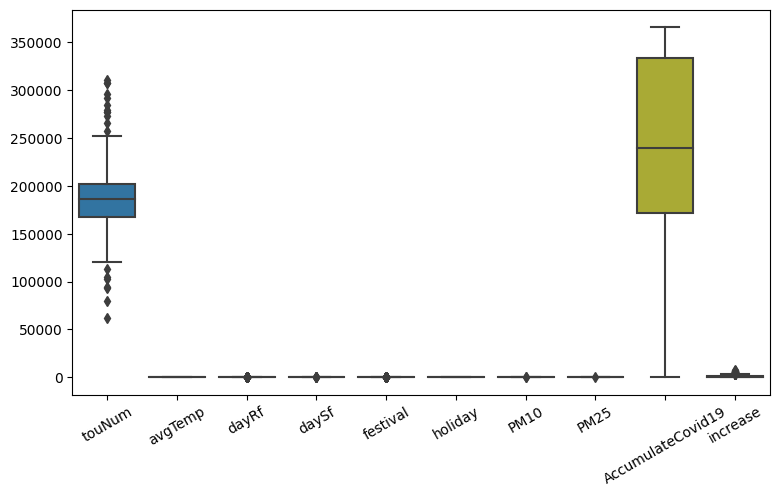

In [8]:
plt.figure(figsize=(9, 5))
jeju_box = sns.boxplot(data=df_jeju)
jeju_box.set_xticklabels(jeju_box.get_xticklabels(), rotation=30)
plt.show()

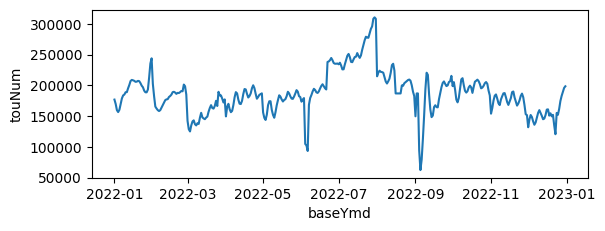

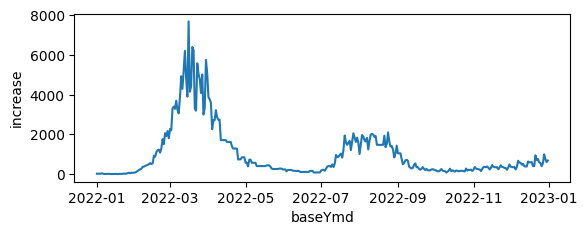

In [9]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_jeju['baseYmd'], y=df_jeju['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_jeju['baseYmd'], y=df_jeju['increase'])
plt.show()

- 강원도

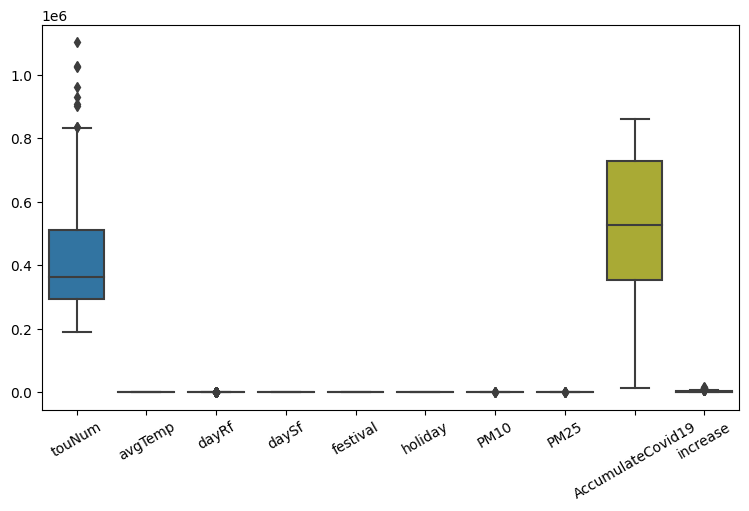

In [10]:
plt.figure(figsize=(9, 5))
gangwon_box = sns.boxplot(data=df_gangwon)
gangwon_box.set_xticklabels(gangwon_box.get_xticklabels(), rotation=30)
plt.show()

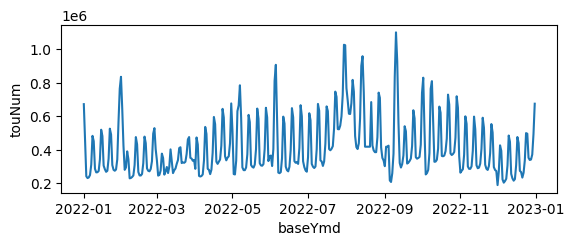

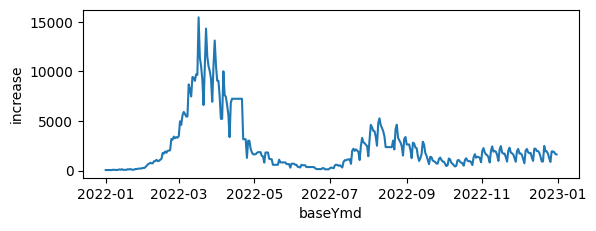

In [11]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_gangwon['baseYmd'], y=df_gangwon['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_gangwon['baseYmd'], y=df_gangwon['increase'])
plt.show()

- 전라남도

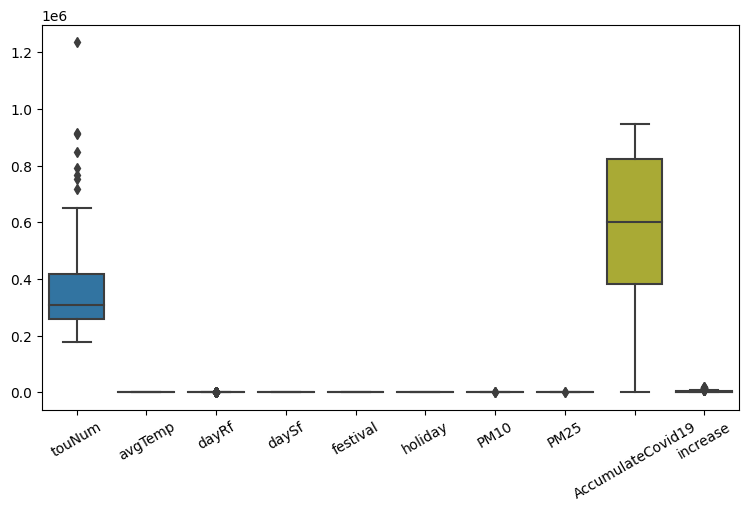

In [12]:
plt.figure(figsize=(9, 5))
jeonju_box = sns.boxplot(data=df_jeonju)
jeonju_box.set_xticklabels(jeonju_box.get_xticklabels(), rotation=30)
plt.show()

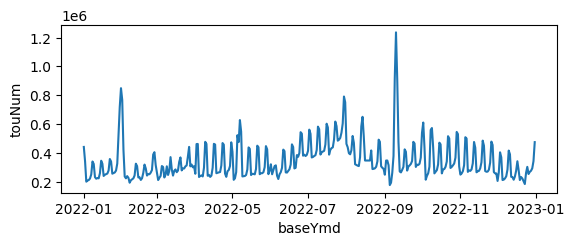

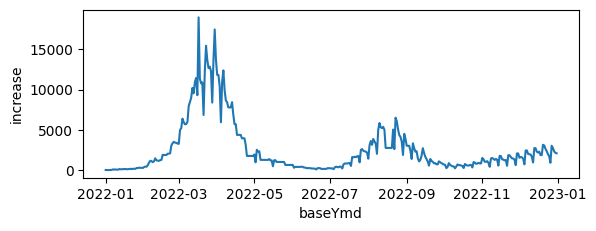

In [13]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_jeonju['baseYmd'], y=df_jeonju['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_jeonju['baseYmd'], y=df_jeonju['increase'])
plt.show()

- 부산광역시

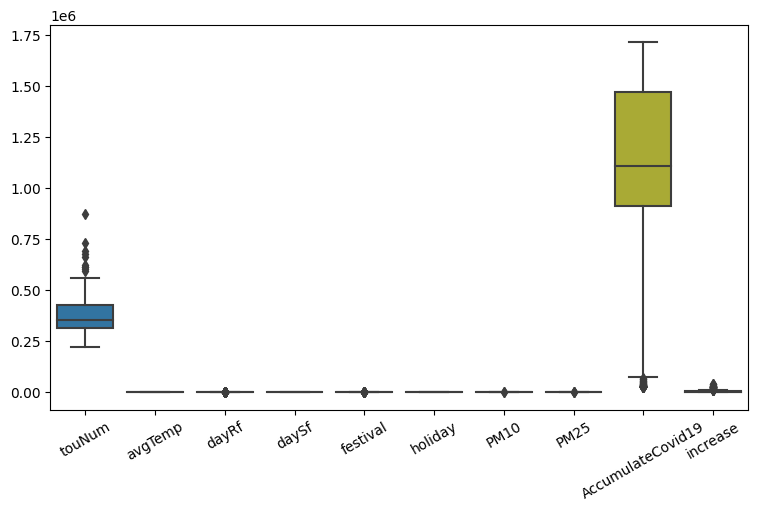

In [14]:
plt.figure(figsize=(9, 5))
busan_box = sns.boxplot(data=df_busan)
busan_box.set_xticklabels(busan_box.get_xticklabels(), rotation=30)
plt.show()

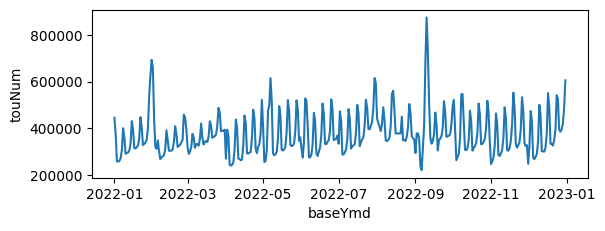

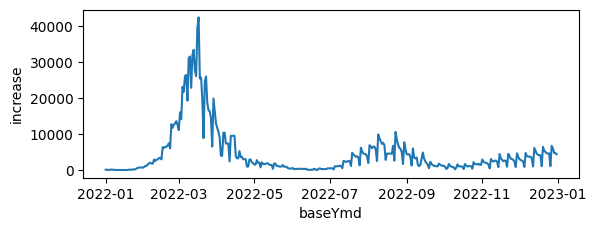

In [15]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_busan['baseYmd'], y=df_busan['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_busan['baseYmd'], y=df_busan['increase'])
plt.show()

- 충청북도

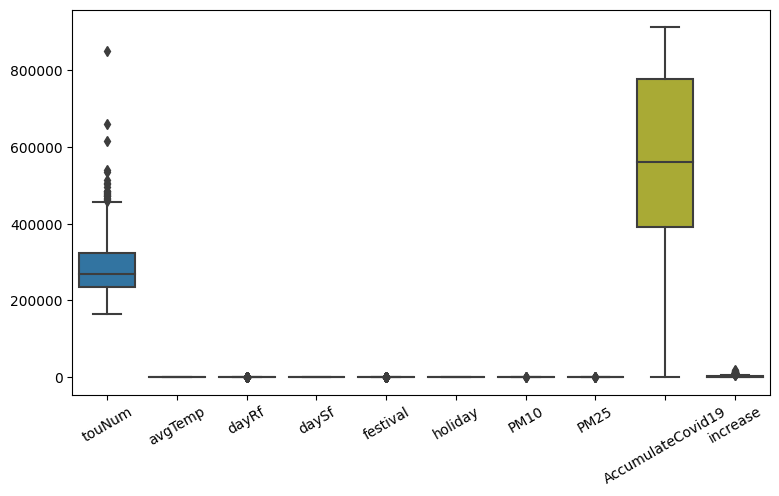

In [16]:
plt.figure(figsize=(9, 5))
chungju_box = sns.boxplot(data=df_chungju)
chungju_box.set_xticklabels(chungju_box.get_xticklabels(), rotation=30)
plt.show()

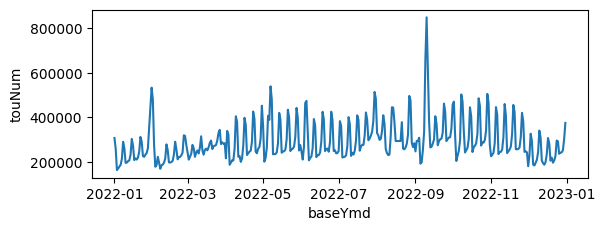

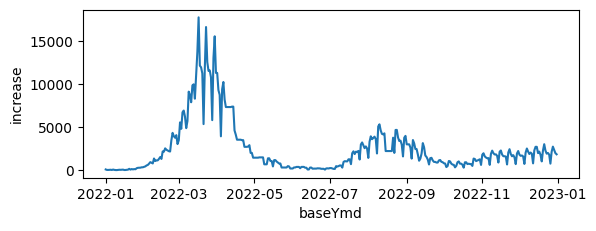

In [17]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_chungju['baseYmd'], y=df_chungju['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_chungju['baseYmd'], y=df_chungju['increase'])
plt.show()

### 5. 가설검정 (서울특별시, 제주특별자치도)

- 귀무가설 : 해외여행을 못 가게 되었지만, 코로나의 위험성에 국내 여행을 자제할 것이다.

- 대립가설 : 해외여행을 못 가게 된 사람들이 국내 여행을 많이 찾게 되면서 코로나 추세와는 상관없이 관광객이 많을 것이다.

- 서울특별시

In [18]:
# 독립변수와 종속변수 나누어 저장
dfX_seoul = df_seoul.drop(columns=['touNum', 'baseYmd'])
dfy_seoul = df_seoul.drop(columns=['baseYmd', 'avgTemp', 'dayRf', 'daySf', 'festival', 'holiday', 'PM10', 'PM25', 'AccumulateCovid19', 'increase'])

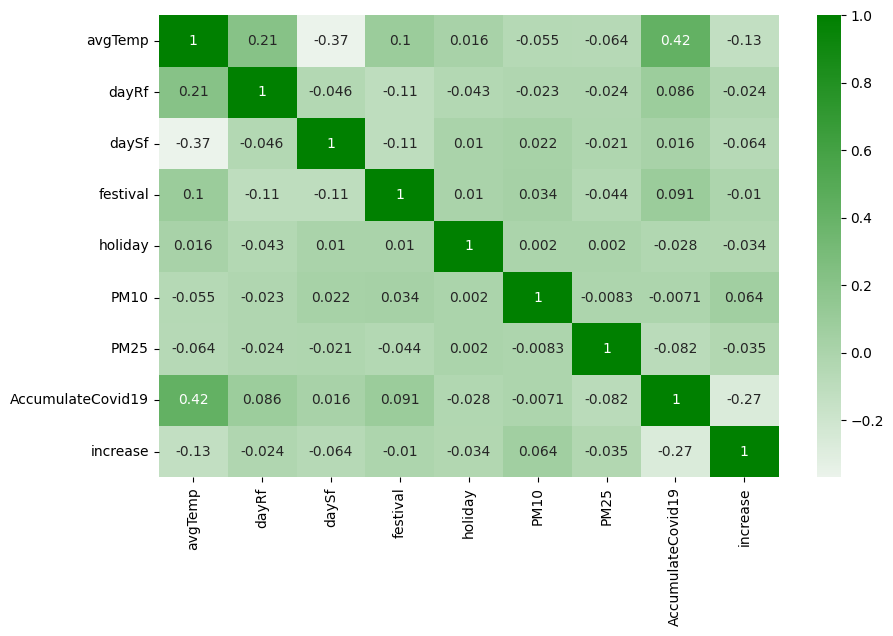

In [19]:
plt.figure(figsize=(10, 6))
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(dfX_seoul.corr(), annot=True, cmap=cmap)
plt.show()

In [20]:
# 서울특별시 다중공선성 조사
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(dfX_seoul.values, i) for i in range(dfX_seoul.shape[1])]
vif["변수"] = dfX_seoul.columns
vif = vif.sort_values("VIF").reset_index(drop=True)
vif

,VIF,변수
0,1.004601,PM25
1,1.017198,PM10
2,1.141480,dayRf
3,1.249114,daySf
4,1.271484,festival
5,1.324395,increase
6,1.377763,holiday
7,3.655597,avgTemp
8,4.002285,AccumulateCovid19


In [45]:
# 학습용 7 : 검증용 3 avgTemp + dayRf + daySf + festival + holiday + PM10 + PM25 + AccumulateCovid19 + 
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("AccumulateCovid19 ~ avgTemp + dayRf + daySf + festival + holiday + PM10 + PM25 + touNum + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      AccumulateCovid19   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     33.91
Date:                Mon, 27 Mar 2023   Prob (F-statistic):           9.10e-14
Time:                        12:40:45   Log-Likelihood:                -3987.9
No. Observations:                 255   AIC:                             7982.
Df Residuals:                     252   BIC:                             7992.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.089e+05   6.76e+05     -0.900      0.369   -1.94e+06    7.23e+05
touNum         2.9264      0.435      6.729      0.000       2.070       3.783
increase     -23.9445      5.325     -4.497      0.000     -34.432     -13.457
==============================================================================
Omnibus:                       17.391   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.634
Skew:                          -0.671   Prob(JB):                     5.45e-05
Kurtosis:                       2.778   Cond. No.                     1.10e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 제주특별자치도

In [ ]:
# 독립변수와 종속변수 나누어 저장
dfX_jeju = df_jeju.drop(columns=['touNum', 'baseYmd'])
dfy_jeju = df_jeju.drop(columns=['baseYmd', 'avgTemp', 'dayRf', 'daySf', 'festival', 'holiday', 'PM10', 'PM25', 'AccumulateCovid19', 'increase'])

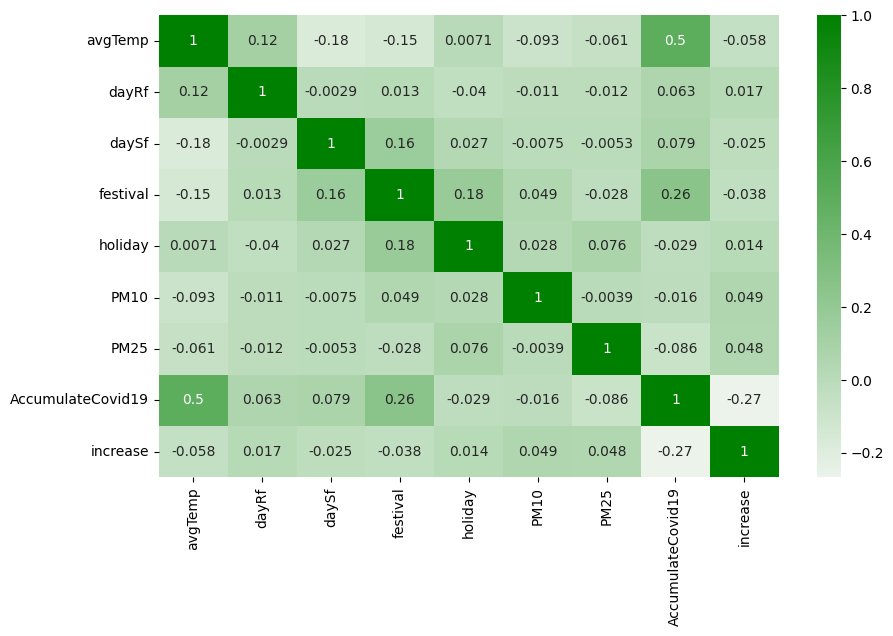

In [ ]:
plt.figure(figsize=(10, 6))
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(dfX_jeju.corr(), annot=True, cmap=cmap)
plt.show()

In [ ]:
# 제주특별자치도 다중공선성 조사
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(dfX_seoul.values, i) for i in range(dfX_jeju.shape[1])]
vif["변수"] = dfX_jeju.columns
vif = vif.sort_values("VIF").reset_index(drop=True)
vif

,VIF,변수
0,1.004601,PM25
1,1.017198,PM10
2,1.141480,dayRf
3,1.249114,daySf
4,1.271484,festival
5,1.324395,increase
6,1.377763,holiday
7,3.655597,avgTemp
8,4.002285,AccumulateCovid19


In [38]:
# 학습용 7 : 검증용 3 
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("increase ~ avgTemp + dayRf + daySf + festival + holiday + PM10 + PM25 + touNum + AccumulateCovid19", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               increase   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.019
Date:                Mon, 27 Mar 2023   Prob (F-statistic):              0.422
Time:                        12:38:59   Log-Likelihood:                -2181.0
No. Observations:                 255   AIC:                             4380.
Df Residuals:                     246   BIC:                             4412.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1912.1507    490.433      3.899      0.000     946.168    2878.133
avgTemp        0.0803     11.484      0.007      0.994     -22.539      22.700
dayRf         -0.4873      5.776     -0.084      0.933     -11.864      10.889
daySf       -186.4069    430.448     -0.433      0.665   -1034.241     661.427
festival    -269.4013    200.255     -1.345      0.180    -663.835     125.033
holiday      220.3763    176.268      1.250      0.212    -126.811     567.563
PM10         705.5565    916.139      0.770      0.442   -1098.920    2510.033
PM25        1082.2477   1292.824      0.837      0.403   -1464.168    3628.664
touNum        -0.0053      0.003     -1.843      0.067      -0.011       0.000
==============================================================================
Omnibus:                      117.722   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.132
Skew:                           2.075   Prob(JB):                     1.73e-83
Kurtosis:                       7.318   Cond. No.                     3.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

시계열분석 및 모델링

In [27]:
# 데이터 분할
X = df_jeju['increase'].values.reshape(-1, 1) # 독립 변수
y = df_jeju['touNum'].values.reshape(-1, 1) # 종속 변수
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# 미래 예측
future_confirmed = [[100], [200], [300]]
future_tourists = model.predict(future_confirmed)
    

MAE: 24464.41, RMSE: 31395.40


- ARIMA (자기회귀모델, AutoRegressive Model)

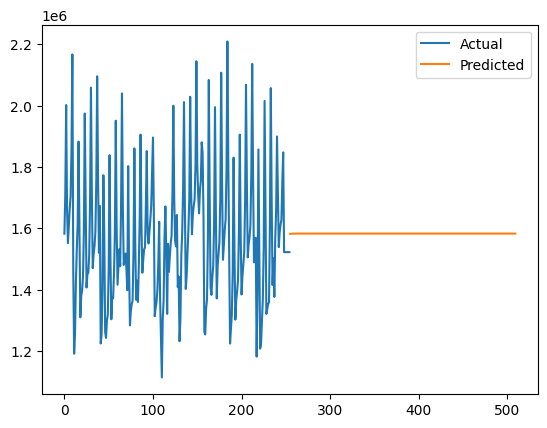

In [57]:
# 날짜를 인덱스로
# df_seoul['baseYmd'] = pd.to_datetime(df_seoul['baseYmd'])
# df_seoul = df_seoul.set_index('baseYmd')

# 마지막 30일을 검증용 데이터로 사용
train_data = df_seoul.iloc[:-110]
test_data = df_seoul.iloc[-255:]

model = ARIMA(train_data['touNum'], order=(1,1,1))
model_fit = model.fit()

# 검증용 데이터를 활용하여 예측
predictions = model_fit.forecast(steps=len(test_data))

# 예측결과 시각화
plt.plot(test_data['touNum'].values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [63]:
# 함수로 만들기

def arima_analysis(data_path, column_name, city, order=(0,1,1), test_size=30):
    # 불러올 데이터
    df = pd.read_csv(data_path, parse_dates=['baseYmd'])
    data_df = df.loc[df['areaNm'] == city]
    # 날짜 인덱스 설정
    data_df = data_df.set_index('baseYmd')
    train_data = data_df.iloc[:-110]
    test_data = data_df.iloc[-255:]
    # 학습용 모델 Train ARIMA model
    model = ARIMA(train_data[column_name], order=order)
    model_fit = model.fit()
    # 예측값 생성
    predictions = model_fit.forecast(steps=len(test_data))
    # 시각화
    plt.plot(test_data[column_name].values, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(f'{column_name} Forecasting with ARIMA Model')
    plt.xlabel('baseYmd')
    plt.ylabel(column_name)
    plt.legend()
    plt.show()


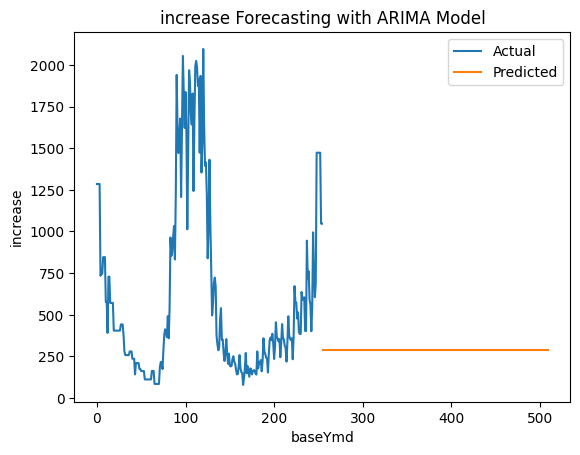

In [64]:
arima_analysis('./data/result_final.csv', 'increase', '제주특별자치도')